# Listening for new data

:::note
In SuperDuperDB, AI models may be configured to listen for newly inserted data.
Outputs will be computed over that data and saved back to the data-backend.
:::

In this example we show how to configure 3 models to interact when new data is added.

1. A featurizing computer vision model (images `->` vectors).
1. 2 models evaluating image-2-text similarity to a set of key-words.

We use an open-source model "CLIP" which we install via `pip` directly from GitHub.
You can read more about installing requirements on our docs [here](../get_started/environment).

In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/3h/p6qzszds1c7gtbmt_2qq0tvm0000gn/T/pip-req-build-spx4v54y
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/3h/p6qzszds1c7gtbmt_2qq0tvm0000gn/T/pip-req-build-spx4v54y
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


We apply our setup to images from the 
[cats and dogs dataset](https://www.kaggle.com/c/dogs-vs-cats). We've prepared a subset especially 
for quick experimentation.

In [3]:
!curl -O https://superduperdb-public-demo.s3.amazonaws.com/images.zip && unzip images.zip
from PIL import Image
import os

data = [f'images/{x}' for x in os.listdir('./images') if x.endswith('png')]
data = [{'img': Image.open(path)} for path in data]

Now that we've prepared these records we can insert this data "directly" into the database with 
a standard insert statement. (Notice however the difference from `pymongo` with the `.execute()` call.)
The same pattern may be applied to other database types.

In [4]:
from superduperdb import superduper, Document

db = superduper('mongomock://')

db['images'].insert_many([Document(r) for r in data[:-1]]).execute()

2024-May-27 11:33:18.45| INFO     | Duncans-MBP.fritz.box| superduperdb.base.build:69   | Data Client is ready. mongomock.MongoClient('localhost', 27017)
2024-May-27 11:33:18.47| INFO     | Duncans-MBP.fritz.box| superduperdb.base.build:42   | Connecting to Metadata Client with engine:  mongomock.MongoClient('localhost', 27017)
2024-May-27 11:33:18.47| INFO     | Duncans-MBP.fritz.box| superduperdb.base.build:155  | Connecting to compute client: None
2024-May-27 11:33:18.47| INFO     | Duncans-MBP.fritz.box| superduperdb.base.datalayer:85   | Building Data Layer
2024-May-27 11:33:18.47| INFO     | Duncans-MBP.fritz.box| superduperdb.base.build:220  | Configuration: 
 +---------------+--------------+
| Configuration |    Value     |
+---------------+--------------+
|  Data Backend | mongomock:// |
+---------------+--------------+
2024-May-27 11:33:18.49| WARNING  | Duncans-MBP.fritz.box| superduperdb.misc.annotations:117  | add is deprecated and will be removed in a future release.
2024

([ObjectId('665453924260c60bfe3e8084'),
  ObjectId('665453924260c60bfe3e8085'),
  ObjectId('665453924260c60bfe3e8086'),
  ObjectId('665453924260c60bfe3e8087'),
  ObjectId('665453924260c60bfe3e8088'),
  ObjectId('665453924260c60bfe3e8089'),
  ObjectId('665453924260c60bfe3e808a'),
  ObjectId('665453924260c60bfe3e808b'),
  ObjectId('665453924260c60bfe3e808c'),
  ObjectId('665453924260c60bfe3e808d'),
  ObjectId('665453924260c60bfe3e808e'),
  ObjectId('665453924260c60bfe3e808f'),
  ObjectId('665453924260c60bfe3e8090'),
  ObjectId('665453924260c60bfe3e8091'),
  ObjectId('665453924260c60bfe3e8092'),
  ObjectId('665453924260c60bfe3e8093'),
  ObjectId('665453924260c60bfe3e8094'),
  ObjectId('665453924260c60bfe3e8095'),
  ObjectId('665453924260c60bfe3e8096'),
  ObjectId('665453924260c60bfe3e8097'),
  ObjectId('665453924260c60bfe3e8098'),
  ObjectId('665453924260c60bfe3e8099'),
  ObjectId('665453924260c60bfe3e809a'),
  ObjectId('665453924260c60bfe3e809b'),
  ObjectId('665453924260c60bfe3e809c'),


We can verify that the images are correctly saved by retrieved a single record:

In [5]:
r = db['images'].find_one().execute()
r

Document({'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=500x338 at 0x13EE96590>, '_fold': 'train', '_schema': 'AUTO:img=pil_image', '_id': ObjectId('665453924260c60bfe3e8084')})

The contents of the `Document` may be accessed by calling `.unpack()`. You can see that the images were saved and retrieved correctly.

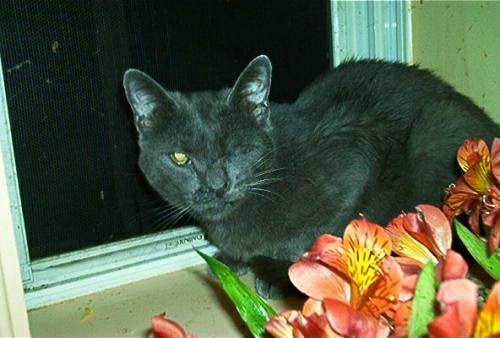

In [6]:
r.unpack()['img']

We now build a `torch` model for text-2-image similarity using the `clip` library. In order to 
save the outputs correctly in the system, we add the `tensor` datatype to the model:

In [7]:
import clip
import torch
from superduperdb.ext.torch import TorchModel, tensor


model, preprocess = clip.load("ViT-B/32", "cpu")

class ImageModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = model

    def forward(self, image_tensors):
        return self.model.encode_image(image_tensors)


dt = tensor(dtype='float', shape=(512,))


image_model = TorchModel(
    identifier='clip_image',
    object=ImageModel(),
    preprocess=preprocess,
    datatype=dt,
    loader_kwargs={'batch_size': 5},
)

We can verify that this model gives us the correct outputs on the added data with the `.predict_one` method:

In [8]:
image_model.predict_one(data[0]['img'])

tensor([ 1.1590e-01, -1.1163e-01,  1.6210e-01,  3.2125e-01,  3.8310e-02,
        -2.9220e-01, -1.6120e-01, -1.0013e+00,  4.9538e-01,  1.4114e-01,
         7.6920e-02,  6.7780e-02, -1.0894e-01,  1.2793e-01, -2.6868e-01,
         4.6839e-01,  5.3715e-01,  7.9151e-02,  2.9155e-02,  2.5880e-01,
        -3.8380e-01,  8.6311e-02,  1.8946e-01,  1.6239e-01, -6.7896e-01,
         6.5299e-02,  4.9489e-01,  1.5839e-01,  8.3728e-02,  5.5632e-02,
        -1.0379e-01,  1.6675e-02, -3.3331e-01,  1.2236e-01,  6.2966e-01,
        -2.9543e-01,  6.5257e-01, -6.9910e-02,  2.0470e-01,  1.9606e+00,
        -1.2133e-01, -5.8945e-02, -1.3498e-01, -1.3249e-01,  2.0738e-01,
        -7.0674e-01,  1.3906e-01,  1.7988e-01,  7.0238e-02, -3.3584e-01,
        -2.3665e-01,  7.9334e-02, -1.0090e-01, -9.1650e-02,  1.7352e-01,
         1.1216e-01,  1.9300e-01,  4.8928e-01, -1.1548e-01,  5.7670e-02,
         6.2232e-01, -3.1829e-01, -2.3148e-01,  2.0030e-01, -4.0209e-02,
        -1.4554e-01,  4.4466e-01,  4.1464e-01, -2.4

Now we'd like to set up this model to compute outputs on the `'img'` key of each record. 
To do that we create a `Listener` (see [here](../apply_api/listener) for more information) which 
"listens" for incoming and existing data, and computes outputs on that data.

When new data is inserted, the model automatically will create outputs on that data. This is a very handy 
feature for productionizing AI and ML, since a data deployment needs to be keep up-to-date as far as possible.

In [9]:
listener = image_model.to_listener(
    select=db['images'].find(),
    key='img',
    identifier='image_predictions',
)

_ = db.apply(listener)

2024-May-27 11:34:16.44| WARNING  | Duncans-MBP.fritz.box| superduperdb.backends.local.artifacts:82   | File /tmp/e1635b227a7f3787dc79524d812915c342701260 already exists
2024-May-27 11:34:17.37| INFO     | Duncans-MBP.fritz.box| superduperdb.backends.local.compute:37   | Submitting job. function:<function method_job at 0x10cd4bec0>


999it [00:00, 107213.29it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.58it/s]


2024-May-27 11:34:49.03| INFO     | Duncans-MBP.fritz.box| superduperdb.components.model:783  | Adding 999 model outputs to `db`
2024-May-27 11:34:49.67| WARNING  | Duncans-MBP.fritz.box| superduperdb.backends.mongodb.query:254  | Some delete ids are not executed , hence halting execution Please note the partially executed operations wont trigger any `model/listeners` unless CDC is active.
2024-May-27 11:34:49.76| SUCCESS  | Duncans-MBP.fritz.box| superduperdb.backends.local.compute:43   | Job submitted on <superduperdb.backends.local.compute.LocalComputeBackend object at 0x13ecc76d0>.  function:<function method_job at 0x10cd4bec0> future:5d4a6013-900c-4582-9680-4043e1407519


We can verify that the outputs are correctly inserted into the documents with this query. 
The outputs are saved in the `listener.outputs` field:

In [10]:
list(listener.outputs_select.limit(1).execute())[0][listener.outputs].unpack()

/Users/dodo/SuperDuperDB/superduperdb/superduperdb/ext/torch/encoder.py:52: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  return torch.from_numpy(array)


tensor([ 1.1590e-01, -1.1163e-01,  1.6210e-01,  3.2125e-01,  3.8310e-02,
        -2.9220e-01, -1.6120e-01, -1.0013e+00,  4.9538e-01,  1.4114e-01,
         7.6920e-02,  6.7780e-02, -1.0894e-01,  1.2793e-01, -2.6868e-01,
         4.6839e-01,  5.3715e-01,  7.9151e-02,  2.9155e-02,  2.5880e-01,
        -3.8380e-01,  8.6311e-02,  1.8946e-01,  1.6239e-01, -6.7896e-01,
         6.5299e-02,  4.9489e-01,  1.5839e-01,  8.3728e-02,  5.5632e-02,
        -1.0379e-01,  1.6675e-02, -3.3331e-01,  1.2236e-01,  6.2966e-01,
        -2.9543e-01,  6.5257e-01, -6.9910e-02,  2.0470e-01,  1.9606e+00,
        -1.2133e-01, -5.8945e-02, -1.3498e-01, -1.3249e-01,  2.0738e-01,
        -7.0674e-01,  1.3906e-01,  1.7988e-01,  7.0238e-02, -3.3584e-01,
        -2.3665e-01,  7.9334e-02, -1.0090e-01, -9.1650e-02,  1.7352e-01,
         1.1216e-01,  1.9300e-01,  4.8928e-01, -1.1548e-01,  5.7670e-02,
         6.2232e-01, -3.1829e-01, -2.3148e-01,  2.0030e-01, -4.0209e-02,
        -1.4554e-01,  4.4466e-01,  4.1464e-01, -2.4

Downstream of this first model, we now can add another smaller model, to classify images with configurable terms. 
Since the dataset is concerned with cats and dogs we create 2 downstream models classifying the images in 2 different ways.

In [11]:
from superduperdb import ObjectModel


class Comparer:
    def __init__(self, words, text_features):
        self.targets = {w: text_features[i] for i, w in enumerate(words)}
        self.lookup = list(self.targets.keys())
        self.matrix = torch.stack(list(self.targets.values()))

    def __call__(self, vector):
        best = (self.matrix @ vector).topk(1)[1].item()
        return self.lookup[best]


cats_vs_dogs = ObjectModel(
    'cats_vs_dogs',
    object=Comparer(['cat', 'dog'], model.encode_text(clip.tokenize(['cat', 'dog']))),
).to_listener(
    select=db['images'].find(),
    key=listener.outputs,
)

            
felines_vs_canines = ObjectModel(
    'felines_vs_canines',
    object=Comparer(['feline', 'canine'], model.encode_text(clip.tokenize(['feline', 'canine']))),
).to_listener(
    select=db['images'].find(),
    key=listener.outputs,
)


db.apply(cats_vs_dogs)
db.apply(felines_vs_canines)

2024-May-27 11:34:50.07| INFO     | Duncans-MBP.fritz.box| superduperdb.backends.local.compute:37   | Submitting job. function:<function method_job at 0x10cd4bec0>


999it [00:00, 130533.01it/s]


2024-May-27 11:34:50.63| INFO     | Duncans-MBP.fritz.box| superduperdb.components.model:783  | Adding 999 model outputs to `db`
2024-May-27 11:34:51.22| WARNING  | Duncans-MBP.fritz.box| superduperdb.backends.mongodb.query:254  | Some delete ids are not executed , hence halting execution Please note the partially executed operations wont trigger any `model/listeners` unless CDC is active.
2024-May-27 11:34:51.22| SUCCESS  | Duncans-MBP.fritz.box| superduperdb.backends.local.compute:43   | Job submitted on <superduperdb.backends.local.compute.LocalComputeBackend object at 0x13ecc76d0>.  function:<function method_job at 0x10cd4bec0> future:3c5da5ea-a4d2-4964-89ed-5691e0e80d4b
2024-May-27 11:34:51.23| INFO     | Duncans-MBP.fritz.box| superduperdb.backends.local.compute:37   | Submitting job. function:<function method_job at 0x10cd4bec0>


999it [00:00, 125897.17it/s]


2024-May-27 11:34:51.51| INFO     | Duncans-MBP.fritz.box| superduperdb.components.model:783  | Adding 999 model outputs to `db`
2024-May-27 11:34:52.08| WARNING  | Duncans-MBP.fritz.box| superduperdb.backends.mongodb.query:254  | Some delete ids are not executed , hence halting execution Please note the partially executed operations wont trigger any `model/listeners` unless CDC is active.
2024-May-27 11:34:52.08| SUCCESS  | Duncans-MBP.fritz.box| superduperdb.backends.local.compute:43   | Job submitted on <superduperdb.backends.local.compute.LocalComputeBackend object at 0x13ecc76d0>.  function:<function method_job at 0x10cd4bec0> future:f46f6471-7895-482d-ab03-ec7344235512


([<superduperdb.jobs.job.ComponentJob at 0x142c03d90>],
 Listener(identifier='component/listener/felines_vs_canines/e92d248d-8ea8-4e2b-8254-5988acfea072', uuid='e92d248d-8ea8-4e2b-8254-5988acfea072', key='_outputs.b55cc5c5-9427-40ee-95a3-227e659cd783', model=ObjectModel(identifier='felines_vs_canines', uuid='65f2761b-9d4c-47fb-a5a9-f5e95c81bda9', signature='*args,**kwargs', datatype=None, output_schema=None, flatten=False, model_update_kwargs={}, predict_kwargs={}, compute_kwargs={}, validation=None, metric_values={}, num_workers=0, object=<__main__.Comparer object at 0x177f42bd0>), select=images.find(), active=True, predict_kwargs={}))

We can verify that both downstream models have written their outputs to the database by querying a document:

In [12]:
r = db['images'].find_one().execute()

print(r[cats_vs_dogs.outputs])
print(r[felines_vs_canines.outputs])

cat
feline


Let's check that the predictions make sense for the inserted images:

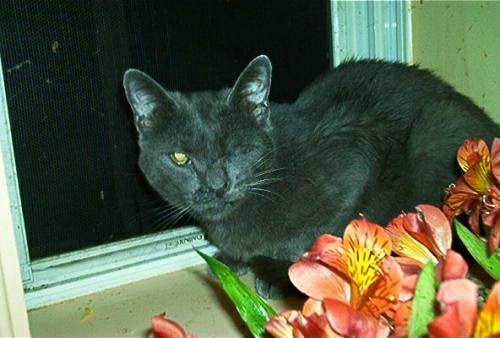

In [13]:
db['images'].find_one({cats_vs_dogs.outputs: 'cat'}).execute()['img']

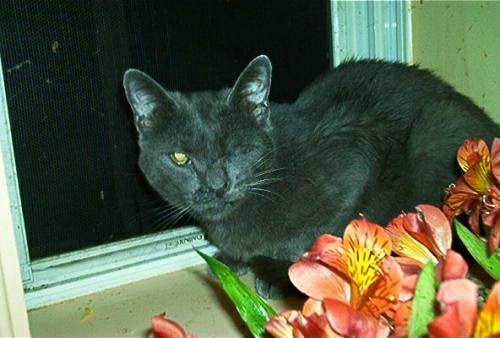

In [17]:
db['images'].find_one({felines_vs_canines.outputs: 'feline'}).execute()['img']

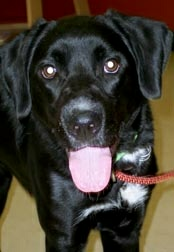

In [18]:
db['images'].find_one({cats_vs_dogs.outputs: 'dog'}).execute()['img']

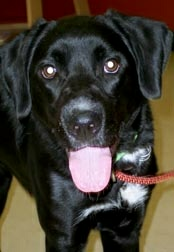

In [19]:
db['images'].find_one({felines_vs_canines.outputs: 'canine'}).execute()['img']

Now that we have installed the models using `Listener`, we can insert new data. This 
data should be automatically processed by the installed models:

In [20]:
db['images'].insert_one(Document({**data[-1], 'new': True})).execute()

2024-May-27 11:36:59.83| WARNING  | Duncans-MBP.fritz.box| superduperdb.misc.annotations:117  | add is deprecated and will be removed in a future release.
2024-May-27 11:37:00.62| INFO     | Duncans-MBP.fritz.box| superduperdb.backends.local.compute:37   | Submitting job. function:<function callable_job at 0x10cd4be20>
2024-May-27 11:37:00.62| SUCCESS  | Duncans-MBP.fritz.box| superduperdb.backends.local.compute:43   | Job submitted on <superduperdb.backends.local.compute.LocalComputeBackend object at 0x13ecc76d0>.  function:<function callable_job at 0x10cd4be20> future:ce572425-a6bd-4170-bad9-6ff56598388d
2024-May-27 11:37:00.90| INFO     | Duncans-MBP.fritz.box| superduperdb.backends.local.compute:37   | Submitting job. function:<function method_job at 0x10cd4bec0>


1it [00:00, 305.06it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.75it/s]


2024-May-27 11:37:01.54| INFO     | Duncans-MBP.fritz.box| superduperdb.components.model:783  | Adding 1 model outputs to `db`
2024-May-27 11:37:01.54| WARNING  | Duncans-MBP.fritz.box| superduperdb.backends.mongodb.query:254  | Some delete ids are not executed , hence halting execution Please note the partially executed operations wont trigger any `model/listeners` unless CDC is active.
2024-May-27 11:37:01.54| SUCCESS  | Duncans-MBP.fritz.box| superduperdb.backends.local.compute:43   | Job submitted on <superduperdb.backends.local.compute.LocalComputeBackend object at 0x13ecc76d0>.  function:<function method_job at 0x10cd4bec0> future:189c7a61-61f3-4fbc-837c-4bdd38d6241d
2024-May-27 11:37:01.54| INFO     | Duncans-MBP.fritz.box| superduperdb.backends.local.compute:37   | Submitting job. function:<function method_job at 0x10cd4bec0>


1it [00:00, 319.59it/s]


2024-May-27 11:37:01.55| INFO     | Duncans-MBP.fritz.box| superduperdb.components.model:783  | Adding 1 model outputs to `db`
2024-May-27 11:37:01.55| WARNING  | Duncans-MBP.fritz.box| superduperdb.backends.mongodb.query:254  | Some delete ids are not executed , hence halting execution Please note the partially executed operations wont trigger any `model/listeners` unless CDC is active.
2024-May-27 11:37:01.55| SUCCESS  | Duncans-MBP.fritz.box| superduperdb.backends.local.compute:43   | Job submitted on <superduperdb.backends.local.compute.LocalComputeBackend object at 0x13ecc76d0>.  function:<function method_job at 0x10cd4bec0> future:1c603b81-4891-4d9b-8c1b-48039e77e27d
2024-May-27 11:37:01.55| INFO     | Duncans-MBP.fritz.box| superduperdb.backends.local.compute:37   | Submitting job. function:<function method_job at 0x10cd4bec0>


1it [00:00, 322.39it/s]

2024-May-27 11:37:01.56| INFO     | Duncans-MBP.fritz.box| superduperdb.components.model:783  | Adding 1 model outputs to `db`
2024-May-27 11:37:01.56| WARNING  | Duncans-MBP.fritz.box| superduperdb.backends.mongodb.query:254  | Some delete ids are not executed , hence halting execution Please note the partially executed operations wont trigger any `model/listeners` unless CDC is active.
2024-May-27 11:37:01.56| SUCCESS  | Duncans-MBP.fritz.box| superduperdb.backends.local.compute:43   | Job submitted on <superduperdb.backends.local.compute.LocalComputeBackend object at 0x13ecc76d0>.  function:<function method_job at 0x10cd4bec0> future:a5b04a66-feac-4270-8685-edb0de90142f


([ObjectId('6654543b4260c60bfe3e8479')],
 TaskWorkflow(database=<superduperdb.base.datalayer.Datalayer object at 0x13ed87e90>, G=<networkx.classes.digraph.DiGraph object at 0x15c991d10>))

We can verify this by querying the data again:

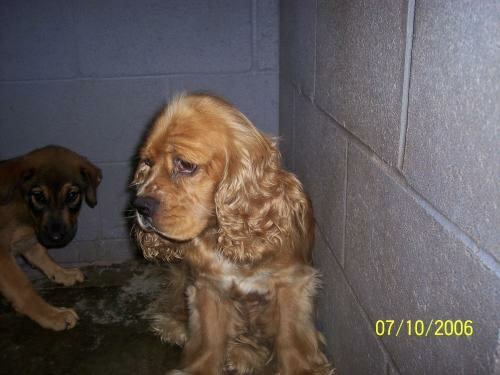

In [21]:
r = db['images'].find_one({'new': True}).execute().unpack()
r['img']

You see here that the models have been called in the correct order on the newly added data and the outputs saved 
to the new record:

In [22]:
r['_outputs']

{'b55cc5c5-9427-40ee-95a3-227e659cd783': tensor([-1.9784e-01, -1.1985e-02,  1.5070e-02,  2.3934e-01,  9.1826e-02,
         -6.8618e-01,  5.9504e-01, -1.3494e+00, -1.2732e-01,  1.8213e-01,
         -2.4697e-01,  4.2079e-01,  5.8837e-03, -6.9505e-02,  3.9881e-01,
         -1.6329e-01,  1.0990e+00, -2.4527e-01,  4.1645e-01,  2.2653e-01,
         -4.2598e-01, -1.3891e-01,  3.8267e-01, -4.2262e-01,  4.2060e-02,
          1.8807e-01,  5.9752e-01,  2.3998e-01,  5.2914e-01,  6.6496e-02,
          2.9223e-01,  3.7576e-01, -2.6834e-01, -3.8394e-01, -5.1581e-01,
          6.0321e-02,  4.3297e-01, -9.6605e-02, -4.9369e-01,  1.7737e+00,
         -5.3931e-01, -3.9127e-01,  1.7854e-01, -2.3078e-01,  2.8036e-01,
          1.3256e-01,  1.7078e-01, -1.3245e-02, -1.1761e-01,  4.4366e-02,
         -2.0976e-01,  4.0344e-02, -3.3105e-02,  1.1045e-01,  4.9561e-01,
          1.8460e-02, -4.0324e-01,  2.0999e-01, -8.3989e-02, -4.0953e-01,
          6.7217e-01,  2.4515e-01,  7.3640e-01, -5.4399e-02, -3.6352e-01